In [1]:
# Import relevant modules
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
import pybird
from importlib import reload
import os
from scipy.interpolate import interp1d
from copy import deepcopy
from scipy.integrate import quad

In [2]:
font = {'size': 14}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'

In [3]:
zpk = 0.57

In [4]:
from scipy.optimize import fsolve

def get_masses(sum_masses, hierarchy='NH'):
    # a function returning the three masses given the Delta m^2, the total mass, and the hierarchy (e.g. 'IN' or 'IH')
    # Values are in the latest PDG
    # any string containing letter 'n' will be considered as refering to normal hierarchy
    if 'n' in hierarchy.lower():
        # Normal hierarchy massive neutrinos. Calculates the individual
        # neutrino masses from M_tot_NH and deletes M_tot_NH
        delta_m_squared_21 = 7.37e-5
        delta_m_squared_31 = 2.56e-3
        def m1_func(m1, M_tot):
            return M_tot**2 - (m1 + np.sqrt(m1**2 + delta_m_squared_21) + np.sqrt(m1**2 + delta_m_squared_31))**2
        m1, opt_output, success, output_message = fsolve(
            m1_func, sum_masses/3., (sum_masses), full_output=True, xtol=1e-04, maxfev=500)
        m1 = m1[0]
        m2 = (delta_m_squared_21 + m1**2.)**0.5
        m3 = (delta_m_squared_31 + m1**2.)**0.5
        return m1, m2, m3
    else:
        return None

In [5]:
def load_cosmo(basedir, chainname, skycut=1, nu=False):
    bf = np.loadtxt(os.path.join(basedir, chainname, '%s.bestfit') % chainname)
    if bf[2]>2.: bf[2] /= 100.
    if nu: 
        cosmo = {'omega_b': bf[0], 'omega_cdm': bf[1], 'h': bf[2], 'ln10^{10}A_s': bf[3], 'n_s': bf[4], 
                    'N_ur': 0.00641, 'N_ncdm': 3, 'm_ncdm': r'%g, %g, %g' % get_masses(bf[5])}
            
        print (cosmo)
    else: cosmo = {'omega_b': bf[0], 'omega_cdm': bf[1], 'h': bf[2], 'ln10^{10}A_s': bf[3], 'n_s': bf[4], }
    if nu:
        if skycut ==1: b1c2 = np.array([bf[6], bf[7]])
        elif skycut ==2: b1c2 = np.array([bf[8], bf[9]])
        elif skycut ==3: b1c2 = np.array([bf[10], bf[11]])
        elif skycut ==4: b1c2 = np.array([bf[12], bf[13]])
    else: b1c2 = np.array([bf[5], bf[6]])
    return cosmo, b1c2

In [6]:
cosmo, b1c2 = load_cosmo('/Users/pierre/Documents/github/montepython_public-3.3/wcdm/', 'ncdm_eft_bao', nu=True)

{'omega_b': 0.02218471, 'omega_cdm': 0.1314969, 'h': 0.6893984000000001, 'ln10^{10}A_s': 2.851813, 'n_s': 0.9010484, 'N_ur': 0.00641, 'N_ncdm': 3, 'm_ncdm': '0.0775797, 0.0780532, 0.0926208'}


In [7]:
M = Class()
# cosmo = {'ln10^{10}A_s': 3.044, 'n_s': 0.9649, 'h': 0.6736, 'omega_b': 0.02237, 'omega_cdm': 0.120 }
M.set(cosmo)
M.set({'output': 'mPk', 'P_k_max_h/Mpc': 1.0,'z_max_pk': zpk})
M.compute()
kk = np.logspace(-5, 0, 200) # k in h/Mpc
Pk = np.array([M.pk(ki*M.h(), zpk)*M.h()**3 for ki in kk]) # P(k) in (Mpc/h)**3

In [8]:
bs = [b1c2[0], b1c2[1], -1.17855741,  0.41561274, -3.4946073, 0.99198482, -1.61644689]
# bs = [2., 0.8, 0.2, 0.8, 0.2, -4., 0]
bdict = { "b1": bs[0], "b2": bs[1]/np.sqrt(2.), "b3": bs[2], "b4":  bs[1]/np.sqrt(2.), 
 "cct": bs[3], "cr1": bs[4], 'ce0': bs[5], 'ce2': bs[6], 'ce1': 0. }   
print (bdict)

{'b1': 2.049033, 'b2': 0.2982336693846035, 'b3': -1.17855741, 'b4': 0.2982336693846035, 'cct': 0.41561274, 'cr1': -3.4946073, 'ce0': 0.99198482, 'ce2': -1.61644689, 'ce1': 0.0}


boss selection function

In [9]:
z, _, _, n = np.loadtxt(os.path.join('/Users/pierre/Documents/github/montepython_public-3.3/data/pybird/density/Density_galaxies_cmass_ngc_v5.txt'), unpack=True)
n /= np.trapz(n, x=z)
zz = np.linspace(z[0], z[-1], 200)
nz = interp1d(z, n, kind='cubic')(zz)
zs, _, _, ns = np.loadtxt(os.path.join('/Users/pierre/Documents/github/montepython_public-3.3/data/pybird/density/Density_galaxies_cmass_sgc_v5.txt'), unpack=True)
ns /= np.trapz(ns, x=zs)
zl, _, _, nl = np.loadtxt(os.path.join('/Users/pierre/Documents/github/montepython_public-3.3/data/pybird/density/Density_galaxies_lowz_ngc_v5.txt'), unpack=True)
nl /= np.trapz(nl, x=zl)

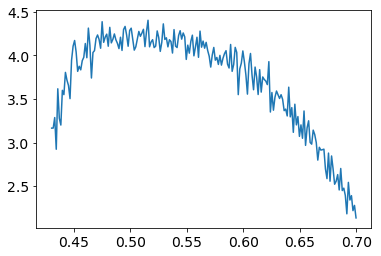

In [10]:
plt.plot(zz, nz)

Gaussian

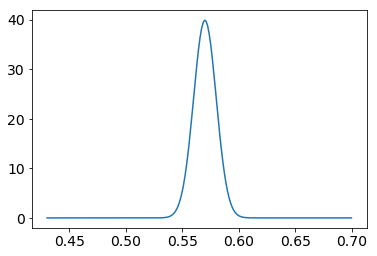

In [11]:
zg = zz#np.linspace(zpk-0.3, zpk+0.3, 100)
sigmaz = 0.01
def Gaussian(z, p=(zpk, sigmaz)):
    zc, dz = p
    return np.exp(-0.5*(z-zc)**2/dz**2)
ng = Gaussian(zg)
ng /= np.trapz(ng, x=zg)
plt.plot(zg, ng)

In [ ]:
def comoving_distance(z): return M.angular_distance(z)*(1+z)

### Correlation function

In [36]:
from scipy.special import spherical_jn
from cubature import cubature

ss = np.array([M.angular_distance(z)*(1+z) for z in zz]) 
D = np.array([M.scale_independent_growth_factor(z) for z in zz])
H = np.array([M.Hubble(z)*(1+z) for z in zz])
kernel = ss**2 / H * nz
ikernel = interp1d(zz, kernel, kind='cubic')
def iker(z): return ikernel(z)

z0 = np.arange(0, 1, 0.001)
s0 = np.array([M.angular_distance(z)*(1+z) for z in z0]) 
is0 = interp1d(z0, s0, kind='cubic')
def comoving_distance(z): return is0(z)

def integrand_norm(zz):
    z1 = zz[:, 0]
    z2 = zz[:, 1]
    return iker(z1) * iker(z2)

kernelD = ss**2 / H * nz * D
ikernelD = interp1d(zz, kernelD, kind='cubic')
def ikerD(z): return ikernelD(z)

def integrand_dd(zz):
    z1 = zz[:, 0]
    z2 = zz[:, 1]
    return ikerD(z1) * ikerD(z2)

In [37]:
sp = np.arange(1, 500, 5)

def get_norm():
    val, err = cubature(integrand_norm, 2, 1, np.array([zz[0], zz[0]])+1e-3, np.array([zz[-1], zz[-1]])-1e-3,
                        abserr=1e-4, relerr=1e-4, maxEval=0, adaptive='p', vectorized=True)
    return val

def get_DD():
    val, err = cubature(integrand_dd, 2, 1, np.array([zz[0], zz[0]])+1e-3, np.array([zz[-1], zz[-1]])-1e-3,
                        abserr=1e-4, relerr=1e-4, maxEval=0, adaptive='p', vectorized=True)
    return val

In [38]:
norm = get_norm()

In [39]:
DD = get_DD()

In [40]:
DDfid = M.scale_independent_growth_factor(zpk)**2
print (DD/norm/DDfid)

[1.00556304]


### Power spectrum

In [118]:
def integrand_convol(zz, k, p):
    z1 = zz[:, 0]
    z2 = zz[:, 1]
    s = np.array([np.abs( comoving_distance(za)-comoving_distance(zb) ) for za, zb in zip(z1, z2)])
    return 2/np.pi * p**2 * ikerD(z1) * ikerD(z2) * spherical_jn(0, k*s) * spherical_jn(0, p*s)

def integrand_norm_ps(zz, k, p):
    z1 = zz[:, 0]
    z2 = zz[:, 1]
    s = np.array([np.abs( comoving_distance(za)-comoving_distance(zb) ) for za, zb in zip(z1, z2)])
    return 2/np.pi * p**2 * iker(z1) * iker(z2) * spherical_jn(0, k*s) * spherical_jn(0, p*s)


In [119]:
kk = np.arange(0.01, 0.3, 0.02)
pp = np.geomspace(1e-4, 10, 30) #np.arange(0.01, 0.6, 0.02) # pp = np.array([0.01])
#pp = np.concatenate([ np.geomspace(1e-3, 0.02, 10, endpoint=False) , np.arange(0.02, 2, 0.01) ])

def get_convol():
    res = np.zeros(shape=(len(kk), len(pp)))
    for i, k in enumerate(kk):
        for j, p in enumerate(pp):
            val, err = cubature(integrand_convol, 2, 1, np.array([zz[0], zz[0]])+1e-3, np.array([zz[-1], zz[-1]])-1e-3, args=(k,p), 
                                abserr=1e-4, relerr=1e-2, maxEval=0, adaptive='p', vectorized=True)
            res[i,j] = val
    return res

def get_norm_ps():
    res = np.zeros(shape=(len(kk), len(pp)))
    for i, k in enumerate(kk):
        for j, p in enumerate(pp):
            val, err = cubature(integrand_norm_ps, 2, 1, np.array([zz[0], zz[0]])+1e-3, np.array([zz[-1], zz[-1]])-1e-3, args=(k,p), 
                                abserr=1e-4, relerr=1e-2, maxEval=0, adaptive='p', vectorized=True)
            res[i,j] = val
    return res

In [117]:
M = Class()
cosmo = { 'ln10^{10}A_s': 3.044, 'n_s': 0.9649, 'h': 0.6736, 'omega_b': 0.02237, 'omega_cdm': 0.120 }
M.set(cosmo)
M.set({'output': 'mPk', 'P_k_max_h/Mpc': 10.0,'z_max_pk': zpk, 'non linear': 'halofit'})
M.compute()
Pp = np.array([M.pk(ki*M.h(), zpk)*M.h()**3 for ki in pp]) # P(k) in (Mpc/h)**3
Pk = np.array([M.pk(ki*M.h(), zpk)*M.h()**3 for ki in kk]) # P(k) in (Mpc/h)**3

In [101]:
convol = get_convol()

In [120]:
norm_ps = get_norm_ps()

0 5 10


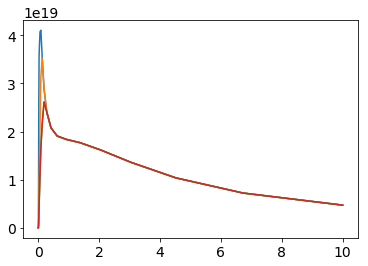

In [112]:
id01 = np.where((kk >= 0.01))[0][0]
id10 = np.where((kk >= 0.1))[0][0]
id20 = np.where((kk >= 0.2))[0][0]
print (id01, id10, id20)
plt.plot(pp, convol[id01] * Pp)
plt.plot(pp, convol[id10] * Pp)
plt.plot(pp, convol[id20] * Pp)

0 5 10


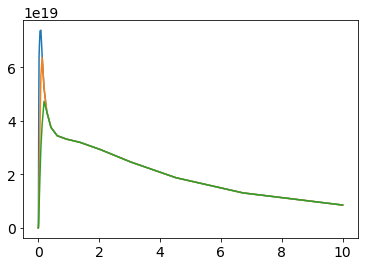

In [127]:
id01 = np.where((kk >= 0.01))[0][0]
id10 = np.where((kk >= 0.1))[0][0]
id20 = np.where((kk >= 0.2))[0][0]
print (id01, id10, id20)
plt.plot(pp, norm_ps[id01] * Pp)
plt.plot(pp, norm_ps[id10] * Pp)
plt.plot(pp, norm_ps[id20] * Pp)

In [108]:
Pperp = np.trapz(convol * Pp, axis=-1, x=pp)

In [121]:
Pnorm = np.trapz(norm_ps, axis=-1, x=pp)

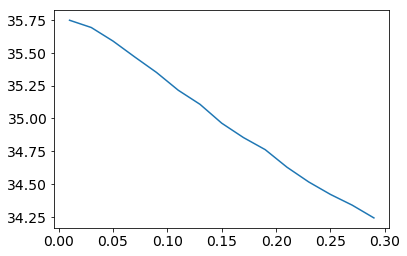

In [128]:
plt.plot(kk, Pperp/Pnorm/DDfid**2)
#plt.plot(kk, Pk)
#plt.yscale('log')

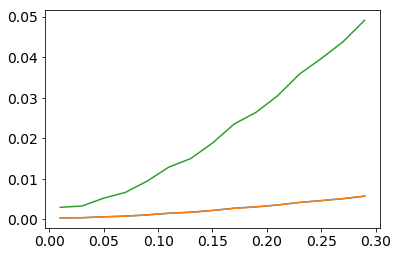

In [126]:
plt.plot(kk, Pperp/norm/DDfid**2 / Pk )
plt.plot(kk, 4 / Pk )
plt.plot(kk, Pperp/Pnorm/DDfid**2 / Pk )

In [134]:
comoving_distance(0.7)-comoving_distance(0.6)

307.4386046469526

In [135]:
comoving_distance(0.7)

array(2587.51380113)

In [136]:
comoving_distance(0.7)-comoving_distance(0.43)

array(1712.40110679)

In [137]:
swindow_config_space = np.loadtxt("../../montepython_public-3.3/data/pybird/Window/window_BOSS_CMASS_NGC_z0p57.dat")
sw = swindow_config_space[:,0]
Qp = np.moveaxis(swindow_config_space[:,1:].reshape(-1,3), 0, -1 )[:3]

In [153]:
sl = np.array([0, comoving_distance(0.7)-comoving_distance(0.43), 10000])
wl = np.array([1, 0, 0])

(1, 1000)

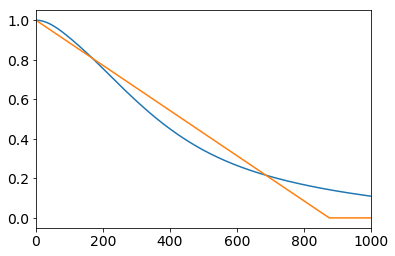

In [158]:
plt.plot(sw, Qp[0])
plt.plot(sl, wl)
plt.xlim(1, 1000)
#plt.xscale('log')